# 8주차 스터디: Multi Assets 퀀트 전략 구현 

    다양한 Assets을 가지고 Event-Driven 퀀트 전략을 구현해 봅시다

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

## 상대 모멘텀 전략 구현

    횡단면 Momentum을 계산하고, 상대적 Momentum이 높은 주식을 매수하는 전략을 구현해 봅시다

In [2]:
# 데이터를 불러옵니다
all_stock = pd.read_csv("new_us_etf_stock.csv",
                        index_col=0, parse_dates=True)

In [3]:
# 종가만 사용할 것이기 때문에, 사용할 수 있는 형태로 데이터프레임을 변환해줍시다
close = pd.pivot_table(data=all_stock,values="Adj Close",
                       index=all_stock.index, columns="Code") \
          .dropna()

In [4]:
# 추후, 수익률 계산을 위해 pct_change 데이터프레임도 만들어 둡시다
close_pct = close.pct_change()

    ChatGpt의 답변: loffset이 뭔지 설명해줘!

In the code close.resample("M", loffset=pd.offsets.BDay()), loffset is a parameter that specifies a time offset to apply after the resampling operation is performed.

In this case, the close dataframe is being resampled to a monthly frequency using the .resample() method. The "M" argument specifies that the resampling frequency should be at the end of each month. However, by default, the resulting data would be aligned to the end of the month, which may not be desirable for certain use cases, such as financial data where we might want to align to business days.

This is where the loffset parameter comes into play. The pd.offsets.BDay() function generates a pandas BusinessDay offset object that specifies a one business day offset. When the loffset parameter is set to pd.offsets.BDay(), it tells pandas to shift the resampled data by one business day so that it is aligned with the last business day of each month instead of the last calendar day of each month.

In [5]:
# 상대 모멘텀(월간) 계산
momentum = close.resample("M", loffset=pd.offsets.BDay())\
                .last() \
                .pct_change()

C:\Users\user\AppData\Local\Temp\ipykernel_14168\1674055238.py:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  momentum = close.resample("M", loffset=pd.offsets.BDay())\


In [6]:
# 상대 모멘텀의 순위를 구해서 상위 50%의 모멘텀을 기록한 주식만 추출하기 위해 rank로 변환해준다
rank = momentum.rank(pct=True, axis=1)
# 랭크 조건에 안 맞으면 0으로 변경한다(매수하지 않을 거)
rank_screener = np.where(rank > 0.5, 1, 0) # signal에 따라서 전부 equal weight로 1로 일괄로 바꾸었다(전략을 짜는 사람의 마음)

In [7]:
# 판다스 곱으로 수익률을 계산할 거라서 데이터프레임으로 바꿔준다
tmp = pd.DataFrame(rank_screener, 
                   index=rank.index,
                   columns=rank.columns)

In [8]:
# Monthly로 기록된 데이터를 Daily로 Reindex해주고 / 포지션을 기록한 1또는 0을 ffill해준다
mp = tmp.reindex(close.index).ffill()

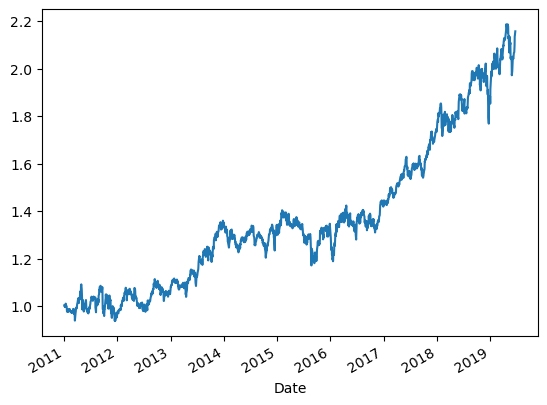

In [9]:
# 리턴확인
((mp * close_pct).replace(0.0, np.nan) + 1).mean(axis=1).cumprod().plot();

# Multi Assets 이평선 전략

Week 7에서 배웠던 내용의 심화버전입니다

    20일 이평선을 뚫으면 사고, 반대일 경우 파는 전략을 Multi Assets에 대해 구현해보자

In [10]:
# 앞에서 사용했던 똑같은 데이터 프레임을 사용
close_pct.head() # close

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-19,-0.005511,0.003959,0.000246,0.004235,0.000833,0.002047,-0.005805,0.014801,0.002751,0.000856,-0.007887,0.007595
2010-11-22,0.021615,0.033794,0.002934,0.012652,0.009682,-0.005254,0.001557,0.016081,-0.000831,-0.009406,-0.004827,-0.000184
2010-11-23,-0.014775,-0.012853,0.000245,-0.006830,0.006967,-0.024354,-0.023708,-0.011042,-0.014477,-0.012948,-0.002853,-0.013056
2010-11-24,0.019661,0.053805,-0.004756,0.000839,-0.001711,0.006917,0.009952,0.002605,0.014774,0.023393,0.032332,0.006335


In [11]:
# 이동평균 계산 후, Buffer Data Drop 시켜줌
ma = close.rolling(window=20).mean()
ma_drop = ma.loc[~ma.isin([np.nan]).any(1)]

C:\Users\user\AppData\Local\Temp\ipykernel_14168\3021544697.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  ma_drop = ma.loc[~ma.isin([np.nan]).any(1)]


In [12]:
# 가격 df도 Buffer Data를 Drop 시켜줌
close_drop = close.loc[~ma.isin([np.nan]).any(1)]
close_pct_drop = close_pct.loc[~ma.isin([np.nan]).any(1)]

C:\Users\user\AppData\Local\Temp\ipykernel_14168\3465321184.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  close_drop = close.loc[~ma.isin([np.nan]).any(1)]
C:\Users\user\AppData\Local\Temp\ipykernel_14168\3465321184.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  close_pct_drop = close_pct.loc[~ma.isin([np.nan]).any(1)]


In [13]:
# 포지션 여부를 표현할 screen 데이터프레임을 생성한다 (이평선보다 주가가 높으면 1, 아니면 0으로 저장한다)
screen = pd.DataFrame(np.where(ma_drop < close_drop, 1, 0),
                      index=close_drop.index,
                      columns=close_drop.columns)
screen.head()

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-16,1,1,0,0,0,0,1,1,1,1,1,1
2010-12-17,1,1,0,0,0,0,1,1,1,1,1,1
2010-12-20,1,1,0,0,0,0,1,1,1,1,1,0
2010-12-21,1,1,0,0,1,0,1,1,1,1,1,0
2010-12-22,1,1,0,0,0,1,1,1,1,1,1,0


In [14]:
# screen이 1에서 0으로 가면 매도, 0에서 1로 가면 매수를 해준다(반복문 없는 벡터화 구현)
buy_signal = np.where((screen == 1) & (screen.shift(1) == 0), 1, np.nan)
sell_signal = np.where((screen == 0) & (screen.shift(1) == 1), 0, np.nan)

In [15]:
# 두 신호를 결합 ([1,np.nan] + [np.nan, 0]을 [1,0]으로 리턴한다)
combined_signal = np.where(~np.isnan(sell_signal), sell_signal, buy_signal)

combi_signal = pd.DataFrame(combined_signal, 
                            index=close_drop.index,
                            columns=close_drop.columns)

In [16]:
# 신호를 결합한 데이터 프레임을 ffill로 채워줍시다
combi_signal = combi_signal.ffill().fillna(0)
combi_signal.head()

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-22,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


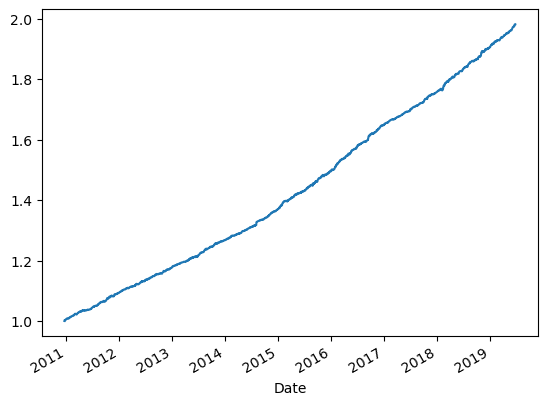

In [17]:
# 이제 전략의 수익률을 계산해야합니다
## 이 곳에서 하나의 전략을 더 결정해야 합니다(자본을 어떻게 투입할 지)
## 여기에서는 가장 쉬운 equal weight 배분전략을 사용하겠습니다
pd.set_option("display.max_rows", 2145)
((close_pct_drop * combi_signal).replace(0.0, np.nan) / 12 + 1).mean(axis=1).cumprod().plot();

## 머신러닝을 활용한 퀀트

    머신러닝으로 다음날 주가를 예측해 포지션을 잡아봅시다

---

**논의할 내용**

1. 정답지 구성: 단순히 1과0?

2. Market Regime에 따른 정답 분포

3. 성능 측정 Metric

4. Cross-Validation 방법론도 달라진다